train acc, test acc | 0.1232, 0.1174
train acc, test acc | 0.9040666666666667, 0.9088
train acc, test acc | 0.9249166666666667, 0.9285
train acc, test acc | 0.9365666666666667, 0.9365
train acc, test acc | 0.94725, 0.9457
train acc, test acc | 0.9537166666666667, 0.9503
train acc, test acc | 0.9579333333333333, 0.954
train acc, test acc | 0.9615666666666667, 0.9577
train acc, test acc | 0.9657166666666667, 0.9593
train acc, test acc | 0.9665166666666667, 0.9606
train acc, test acc | 0.9709666666666666, 0.9633
train acc, test acc | 0.9712666666666666, 0.9644
train acc, test acc | 0.9727666666666667, 0.9647
train acc, test acc | 0.9759, 0.9662
train acc, test acc | 0.9765, 0.9669
train acc, test acc | 0.9778, 0.9657
train acc, test acc | 0.9786666666666667, 0.9687


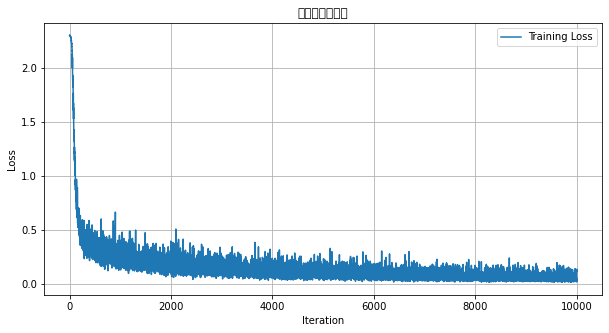

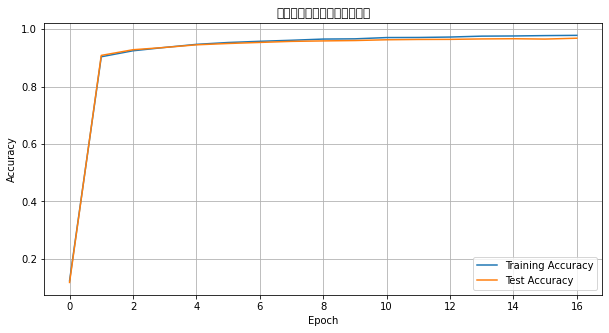

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from collections import OrderedDict

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from dataset.mnist import load_mnist
from common.layers import Affine, Relu, SoftmaxWithLoss
from common.gradient import numerical_gradient


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["Relu1"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db

        return grads


# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# ハイパーパラメータの設定
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# 訓練の記録
train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

# ネットワークの初期化
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 学習ループ
for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size, replace=False)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 誤差逆伝播法によって勾配を求める
    grad = network.gradient(x_batch, t_batch)

    # パラメータの更新
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]

    # 損失関数の値を記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 学習状況の記録
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"train acc, test acc | {train_acc}, {test_acc}")

import matplotlib.pyplot as plt
# 損失関数の推移をプロット
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label="Training Loss")
plt.title("損失関数の推移")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 精度の推移をプロット
epochs = range(len(train_acc_list))  # エポックごとのデータを取得
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_list, label="Training Accuracy")
plt.plot(epochs, test_acc_list, label="Test Accuracy")
plt.title("トレーニング中の精度の推移")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


train acc, test acc | 0.11933333333333333, 0.125
train acc, test acc | 0.9036333333333333, 0.9045


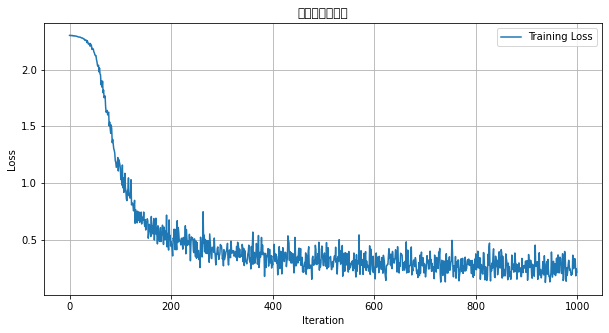

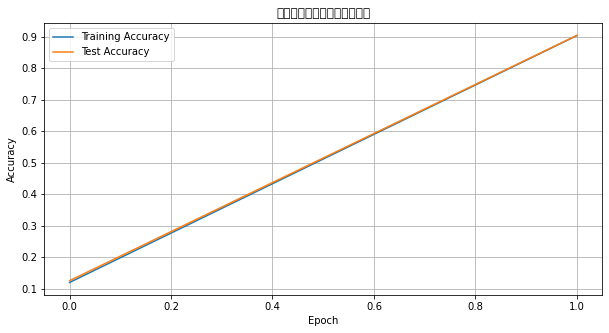

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from collections import OrderedDict

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from dataset.mnist import load_mnist
from common.layers import Affine, Relu, SoftmaxWithLoss
from common.gradient import numerical_gradient


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["Relu1"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db

        return grads


# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# ハイパーパラメータの設定
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# 訓練の記録
train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

# ネットワークの初期化
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 学習ループ
for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size, replace=False)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 誤差逆伝播法によって勾配を求める
    grad = network.gradient(x_batch, t_batch)

    # パラメータの更新
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]

    # 損失関数の値を記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 学習状況の記録
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"train acc, test acc | {train_acc}, {test_acc}")

import matplotlib.pyplot as plt
# 損失関数の推移をプロット
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label="Training Loss")
plt.title("損失関数の推移")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 精度の推移をプロット
epochs = range(len(train_acc_list))  # エポックごとのデータを取得
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_list, label="Training Accuracy")
plt.plot(epochs, test_acc_list, label="Test Accuracy")
plt.title("トレーニング中の精度の推移")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


train acc, test acc | 0.11933333333333333, 0.125
train acc, test acc | 0.9036333333333333, 0.9045


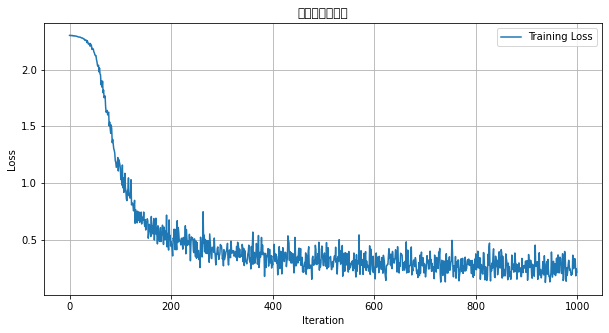

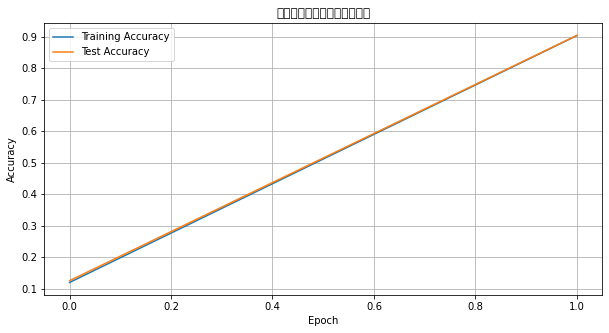

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from collections import OrderedDict

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from dataset.mnist import load_mnist
from common.layers import Affine, Relu, SoftmaxWithLoss
from common.gradient import numerical_gradient


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["Relu1"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db

        return grads


# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# ハイパーパラメータの設定
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# 訓練の記録
train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

# ネットワークの初期化
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 学習ループ
for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size, replace=False)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 誤差逆伝播法によって勾配を求める
    grad = network.gradient(x_batch, t_batch)

    # パラメータの更新
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]

    # 損失関数の値を記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 学習状況の記録
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"train acc, test acc | {train_acc}, {test_acc}")

import matplotlib.pyplot as plt
# 損失関数の推移をプロット
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label="Training Loss")
plt.title("損失関数の推移")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 精度の推移をプロット
epochs = range(len(train_acc_list))  # エポックごとのデータを取得
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_list, label="Training Accuracy")
plt.plot(epochs, test_acc_list, label="Test Accuracy")
plt.title("トレーニング中の精度の推移")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()
